In [1]:
import os, time, random, logging , datetime , cv2 , csv , subprocess
import numpy as np

import tensorflow as tf
print("tf",tf.version.VERSION)
from tensorflow import keras

from utils import globo ,  xdv , tfh5 , rslts


''' GPU CONFIGURATION '''
os.environ["CUDA_VISIBLE_DEVICES"]="3"

tfh5.set_tf_loglevel(logging.ERROR)
tf.debugging.set_log_device_placement(False) #Enabling device placement logging causes any Tensor allocations or operations to be printed.

tfh5.check_gpu_conn()

#tfh5.set_memory_growth()
#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'false'
#tfh5.limit_gpu_gb(2)

tf 2.2.0
/raid/DATASETS/.zuble/vigia /raid/DATASETS/anomaly

Num GPUs Available:  1


Found GPU at: /device:GPU:0


In [ ]:
''' MODEL NAMES 4 LOAD WEIGHTS'''

CFG_RGB = {
    "frame_step":2, #fstep=2 : 24 fps -> 12 , =4 : -> 
    
    "in_height":120,
    "in_width":160,
    
    "batch_size":1,
    "augment":True,
    "shuffle":False,
    
    "ativa" : 'relu',
    "optima" : 'sgd',
    "batch_type" : 0,   # =0 all batch have frame_max or video length // =1 last batch has frame_max frames // =2 last batch has no repetead frames
    "frame_max" : 8000,
    "ckpt_start" : f"{0:0>8}",  #used in train_model: if 00000000 start from scratch, else start from ckpt with config stated
    
    "epochs" : 10
}

model,model_name = tfh5.form_model(CFG_RGB)
    
model = tfh5.load_h5(model,globo.WEIGHTS_PATH,CFG_RGB)

1682977827.0801475_relu_sgd_0_2_8000_history


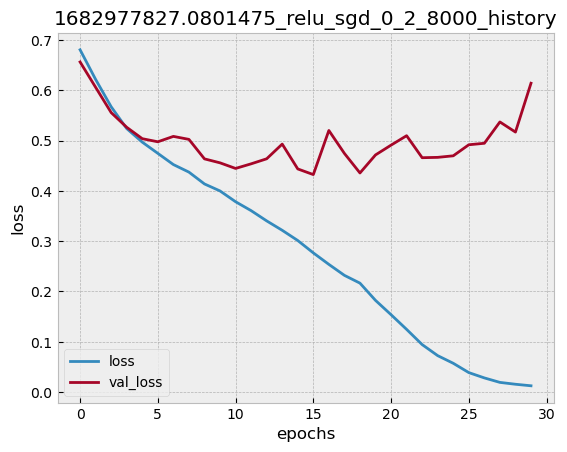

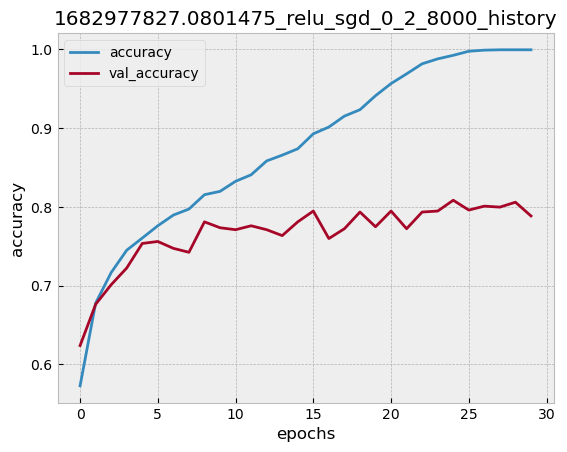

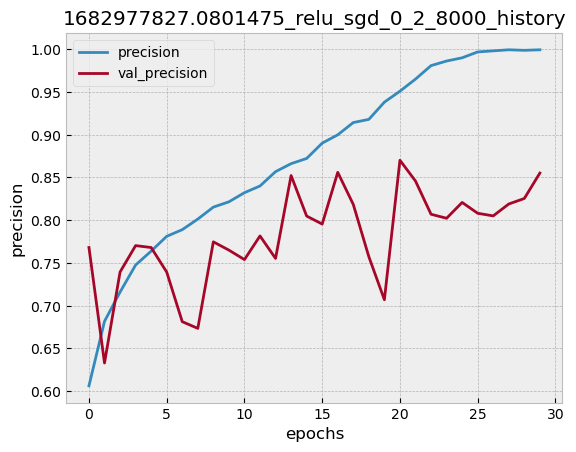

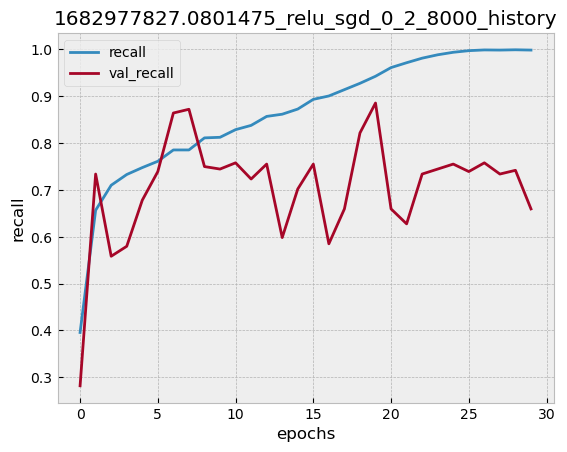

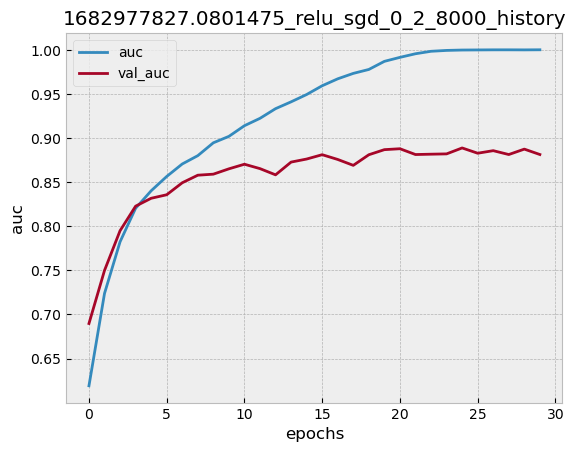

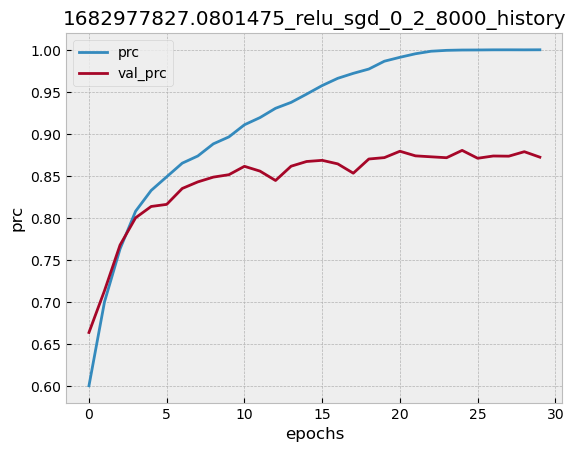

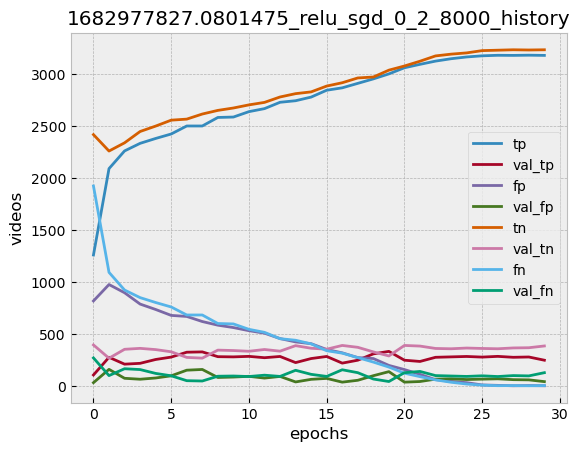

In [4]:
rslts.get_histplot_from_csv(globo.HIST_PATH)